# 01_ENSO_models
### Take the preprocessed anomaly data and regresses out ENSO indices

This notebook imports the preprocess gridded sea surface temperature anomalies (SSTA) data from [00_preprocess.ipynb](00_preprocess.ipynb) and remove signals of El Nino-Southern Oscillatoin variability. 

![preprocess_flow](images/01_ENSO_models.png)


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Import data
- load the monthly preprocessed OISSTv2.1 anomalies


In [2]:
file_path = '/burg/abernathey/users/hillary/oisst_v21/preprocessed_OISSTv21.nc'
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:       (lat: 720, lon: 1440, time: 478)
Coordinates:
  * time          (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat           (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon           (lon) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    lsmask        (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    ssta_notrend  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_trend    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mean          (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    trend         (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    seas          (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  preprocessed monthly averaged OISST v2.1 anomalies

#### Define [Nino SST Indices](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) as SST anomalies averaged across the respected region defined below:
- Niño 3 (5N-5S, 150W-90W)
- Niño 3.4 (5N-5S, 170W-120W)
- Niño 4 (5N-5S, 160E-150W)

![nino-regions](images/nino-regions.gif)

In [3]:
dlon = np.cos(ds.lat * np.pi/180) *111e3
dlat = 111e3 * xr.ones_like(ds.lon)
cell_area = dlon * dlat

Nino3 = ds.ssta_notrend.sel(lat=slice(-5, 5), lon=slice(210, 270)).weighted(cell_area).mean(('lat','lon'))
Nino3_4 = ds.ssta_notrend.sel(lat=slice(-5, 5), lon=slice(190, 240)).weighted(cell_area).mean(('lat','lon'))
Nino4 = ds.ssta_notrend.sel(lat=slice(-5, 5), lon=slice(200, 210)).weighted(cell_area).mean(('lat','lon'))

#### TODO: MEI Index
https://psl.noaa.gov/enso/mei/

#### Regress Nino indices from detrended SST anomalies and remove Nino signal 

In [4]:
indices = np.array([Nino3, Nino3_4, Nino4])
indices_label = ('ssta_nino3', 'ssta_nino3_4', 'ssta_nino4')
da = []

for i in enumerate(indices):
    model = i[1][np.newaxis,:]
    pmodel = np.linalg.pinv(model)
    model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':ds.time.values, 'coeff':[indices_label[i[0]]]}) 
    pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':[indices_label[i[0]]], 'time':ds.time.values})  
    Nino_mod = pmodel_da.dot(ds.ssta_notrend)
    model_ssta = model_da[:,0].dot(Nino_mod[0,:,:])
    da.append(model_ssta)

ssta_Nino = xr.concat(da, dim='coeff')


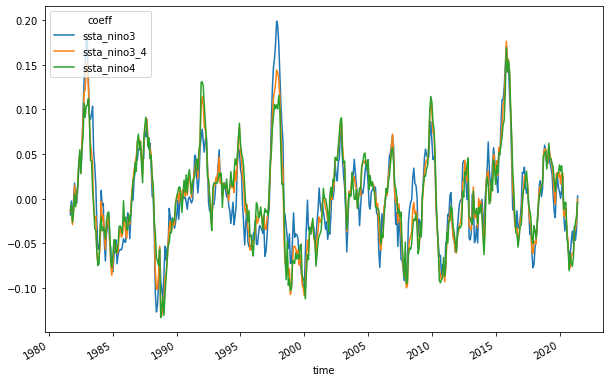

In [5]:
plt.figure(figsize=(10,6))
ssta_Nino.weighted(cell_area).mean(('lat','lon')).plot(hue='coeff');


### Remove Nino anomaies from SSTA 

In [6]:
# SST anomalies with ENSO signal removed
indices_label = ['ssta_no_nino3', 'ssta_no_nino3_4', 'ssta_no_nino4']
da = []
for i in enumerate(ssta_Nino.coeff.values):
    da.append(ds.ssta_notrend-ssta_Nino.isel(coeff=i[0]))
    
ssta_notrend_noNino = xr.concat(da, dim='coeff').assign_coords(coeff=indices_label)


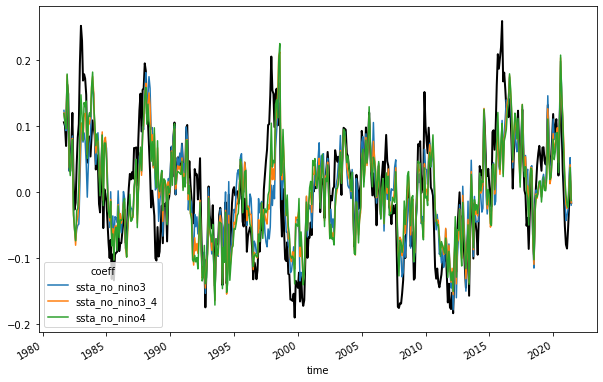

In [7]:
plt.figure(figsize=(10,6))
ds.ssta_notrend.weighted(cell_area).mean(('lat','lon')).plot(color='k', lw=2, label='ssta no trend')
ssta_notrend_noNino.weighted(cell_area).mean(('lat','lon')).plot(hue='coeff');


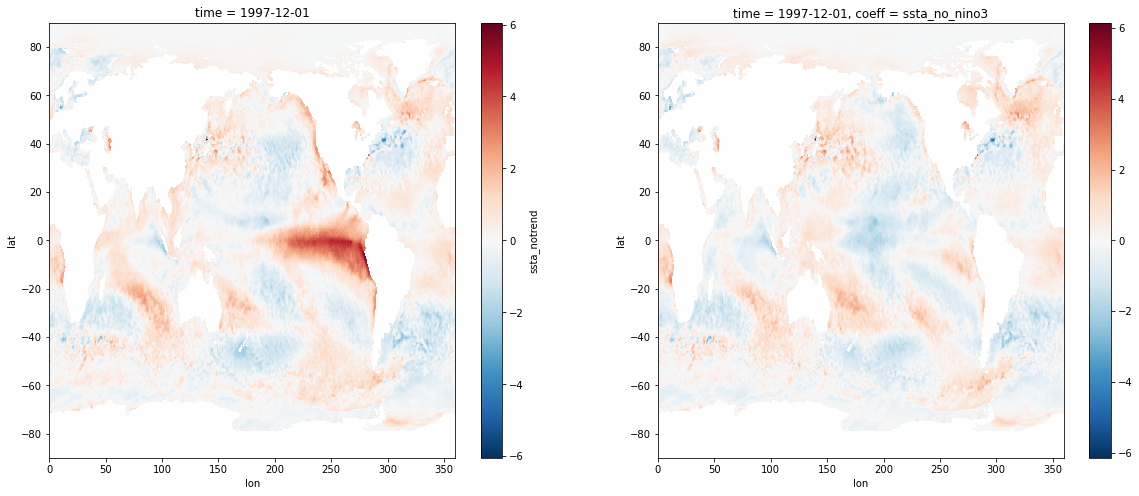

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ds.ssta_notrend.sel(time=('1997-12-01')).plot(ax=ax1)
ssta_notrend_noNino.sel(coeff='ssta_no_nino3', time=('1997-12-01')).plot(ax=ax2);


#### Save as a netCDF

In [9]:
# Specify path to save output 
path = '/burg/abernathey/users/hillary/oisst_v21/'

ds_new = xr.Dataset(
    data_vars=dict(

        Nino3=(['time'], Nino3.data),
        Nino3_4=(['time'], Nino3_4.data),
        Nino4=(['time'], Nino4.data),
        
        ssta_Nino3=(['time', 'lat', 'lon'], ssta_Nino.sel(coeff='ssta_nino3').data),
        ssta_Nino3_4=(['time', 'lat', 'lon'], ssta_Nino.sel(coeff='ssta_nino3_4').data),
        ssta_Nino4=(['time', 'lat', 'lon'], ssta_Nino.sel(coeff='ssta_nino4').data),
        
        ssta_notrend_noNino3=(['time', 'lat', 'lon'], ssta_notrend_noNino.sel(coeff='ssta_no_nino3').data),
        ssta_notrend_noNino3_4=(['time', 'lat', 'lon'], ssta_notrend_noNino.sel(coeff='ssta_no_nino3_4').data),
        ssta_notrend_noNino4=(['time', 'lat', 'lon'], ssta_notrend_noNino.sel(coeff='ssta_no_nino4').data),        
    ),
    coords=dict(
        time=(['time'], ds.time.data),
        lat=(['lat'], ds.lat.data),
        lon=(['lon'], ds.lon.data),
    ),
    attrs=dict(description="preprocessed monthly averaged and detrended OISST v2.1 data"),
)


ds_new.to_netcdf(path+'ENSO_models_OISSTv21.nc', mode='w')
